<a href="https://colab.research.google.com/github/denklewer/ray-custom-agents/blob/master/trpo_ray_ray_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!sudo apt-get install -y build-essential curl unzip psmisc
!pip install cython==0.29.0
!git clone https://github.com/ray-project/ray.git
!ray/ci/travis/install-bazel.sh
!pip install lz4
!pip install setproctitle
!mv ray ray-distr
!pip install -e ray-distr/python/. --verbose  # Add --user if you see a permission denied error.
!apt-get install swig
!apt install -y python3-dev zlib1g-dev libjpeg-dev cmake swig python-pyglet python3-opengl libboost-all-dev libsdl2-dev \
    libosmesa6-dev patchelf ffmpeg xvfb
!pip3 install box2d box2d-kengz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
build-essential is already the newest version (12.4ubuntu1).
unzip is already the newest version (6.0-21ubuntu1).
curl is already the newest version (7.58.0-2ubuntu3.6).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  psmisc
0 upgraded, 1 newly installed, 0 to remove and 7 not upgraded.
Need to get 52.5 kB of archives.
After this operation, 266 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 psmisc amd64 23.1-1ubuntu0.1 [52.5 kB]
Fetched 52.5 kB in 6s (9,380 B/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back t

In [0]:
import sys
import os
sys.path.append(os.path.join("", '/content/ray-distr/python')) # To find local version of the library

In [0]:

import torch
import torch.nn as nn
import torch.nn.functional as F
def conv2d_size_out(size, kernel_size=3, stride=2):
    """
    common use case:
    cur_layer_img_w = conv2d_size_out(cur_layer_img_w, kernel_size, stride)
    cur_layer_img_h = conv2d_size_out(cur_layer_img_h, kernel_size, stride)
    to understand the shape for dense layer's input
    """
    return (size - (kernel_size - 1) - 1) // stride + 1


class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return x.view(x.size(0), -1)



In [4]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import gym
import logging
import ray
from ray import tune
from ray.rllib.evaluation import PolicyGraph, PolicyEvaluator
from ray.rllib.policy.sample_batch import SampleBatch
from ray.rllib.evaluation.metrics import collect_metrics
from ray.rllib.models.pytorch.misc import  valid_padding
import numpy as np

import scipy
import scipy.signal
from ray.rllib.utils.annotations import override
logger = logging.getLogger(__name__)
from ray.rllib.evaluation.postprocessing import compute_advantages,Postprocessing

from torch.autograd import Variable
parser = argparse.ArgumentParser()
parser.add_argument("--gpu", action="store_true")
parser.add_argument("--num-iters", type=int, default=20)
parser.add_argument("--num-workers", type=int, default=2)
from ray.rllib.models.catalog import ModelCatalog, MODEL_DEFAULTS
from collections import defaultdict


class TRPOAgent(nn.Module):
    def __init__(self, observation_space, action_space, config,hidden_size=32):
        '''
        Here you should define your model
        You should have LOG-PROBABILITIES as output because you will need it to compute loss
        We recommend that you start simple:
        use 1-2 hidden layers with 100-500 units and relu for the first try
        '''
        nn.Module.__init__(self)
        config = defaultdict(**config)
        self.config = config
        self.n_actions = action_space.n
        self.state_shape = observation_space.shape
        self.action_space =action_space
        self.observation_space = observation_space
        self.dist_class, self.logit_dim = ModelCatalog.get_action_dist(
        self.action_space, None, torch=True)

                
        if isinstance(self.observation_space, gym.spaces.Discrete):
            self.obs_rank = 1
        else:
            self.obs_rank = len(self.observation_space.shape)
            
        if self.obs_rank > 1:
          w, h, c = (84, 84 , 4)
          self.common = nn.Sequential(
              nn.Conv2d(c, 32, kernel_size=3, stride=2),
              nn.ReLU(),
              nn.Conv2d(32, 32, kernel_size=3, stride=2),
              nn.ReLU(),
              nn.Conv2d(32, 32, kernel_size=3, stride=2),
              nn.ReLU(),
              Flatten())
          convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
          convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
          linear_input_size = convw * convh * 32
          # we want to flatten given images to verctor for dense layers.
          self.fc = nn.Sequential(
              nn.Linear(linear_input_size, 128),
              nn.ReLU()
          )
          self.log_probs = nn.Sequential(
              nn.Linear(128, self.n_actions),
              nn.LogSoftmax()
          )
        else:
          self.model = nn.Sequential(
              nn.Linear(self.state_shape[0], hidden_size),
              nn.ReLU(),
              nn.Linear(hidden_size, self.n_actions),
              nn.LogSoftmax()
          )

    def forward(self, states):
        """
        takes agent's observation (Variable), returns log-probabilities (Variable)
        :param state_t: a batch of states, shape = [batch_size, state_shape]
        """
        
                          
        # Use your network to compute log_probs for given state
        if self.obs_rank > 1:
          states= states.permute(0,3,2,1)
          state_t = self.common(states)
          state_t = self.fc(state_t)
          return self.log_probs(state_t)
        else:
          return self.model(states)

    def get_log_probs(self, states):
        '''
        Log-probs for training
        '''

        return self.forward(states)

    def get_probs(self, states):
        '''
        Probs for interaction
        '''

        return torch.exp(self.forward(states))

    def act(self, obs, sample=True):
        '''
        Samples action from policy distribution (sample = True) or takes most likely action (sample = False)
        :param: obs - single observation vector
        :param sample: if True, samples from \pi, otherwise takes most likely action
        :returns: action (single integer) and probabilities for all actions
        '''

        probs = self.get_probs(Variable(torch.FloatTensor([obs]))).data.numpy()

        if sample:
            action = int(np.random.choice(self.n_actions, p=probs[0]))
        else:
            action = int(np.argmax(probs))

        return action, probs[0]



Instructions for updating:
non-resource variables are not supported in the long term


In [0]:
# UTIL FUNCTIONS
def get_cummulative_returns(r, gamma=1):
  """
  Computes cummulative discounted rewards given immediate rewards
        G_i = r_i + gamma*r_{i+1} + gamma^2*r_{i+2} + ...
        Also known as R(s,a)
  """
  r = np.array(r)
  assert r.ndim >= 1
  return scipy.signal.lfilter([1], [1, -gamma], r[::-1], axis=0)[::-1]

def conjugate_gradient(f_Ax, b, cg_iters=10, residual_tol=1e-10):
    """
    This method solves system of equation Ax=b using iterative method called conjugate gradients
    :f_Ax: function that returns Ax
    :b: targets for Ax
    :cg_iters: how many iterations this method should do
    :residual_tol: epsilon for stability
    """
    p = b.clone()
    r = b.clone()
    x = torch.zeros(b.size())
    rdotr = torch.sum(r * r)
    for i in range(cg_iters):
        z = f_Ax(p)
        v = rdotr / (torch.sum(p * z) + 1e-8)
        x += v * p
        r -= v * z
        newrdotr = torch.sum(r * r)
        mu = newrdotr / (rdotr + 1e-8)
        p = r + mu * p
        rdotr = newrdotr
        if rdotr < residual_tol:
            break
    return x


In [0]:
class CustomPolicy(PolicyGraph):
    """Example of a custom policy graph written from scratch.
    You might find it more convenient to extend TF/TorchPolicyGraph instead
    for a real policy.
    """

    def __init__(self, observation_space, action_space, config):
        PolicyGraph.__init__(self, observation_space, action_space, config)
        # example parameter
        self.w = 1.0
        self.observation_shape = observation_space.shape
        self.n_actions = action_space.n
        self.agent = TRPOAgent(observation_space, action_space, config)
        self.policy = []
        


    def compute_actions(self,
                        obs_batch,
                        state_batches,
                        prev_action_batch=None,
                        prev_reward_batch=None,
                        info_batch=None,
                        episodes=None,
                        **kwargs):
        # return random actions
        actions = []
        action_probs = []
        for obs in obs_batch:
            action, policy = self.agent.act(obs)
            actions.append(action)
            action_probs.append(policy)

        return actions, [], {"action_probs": action_probs}
      
    @override(PolicyGraph)
    def postprocess_trajectory(self,
                               sample_batch,
                               other_agent_batches=None,
                               episode=None):
        traj = {}
        for key in sample_batch:
            traj[key] = np.stack(sample_batch[key])
        traj["cummulative_returns"] = get_cummulative_returns(traj[SampleBatch.REWARDS], gamma= 0.99)
        return SampleBatch(traj)


    def get_flat_params_from(self, model):
        params = []
        for param in model.parameters():
            params.append(param.data.view(-1))

        flat_params = torch.cat(params)
        return flat_params

    def set_flat_params_to(self, model, flat_params):
        prev_ind = 0
        for param in model.parameters():
            flat_size = int(np.prod(list(param.size())))
            param.data.copy_(
                flat_params[prev_ind:prev_ind + flat_size].view(param.size()))
            prev_ind += flat_size

    def get_loss(self, agent, observations, actions, cummulative_returns, old_probs):
        """
        Computes TRPO objective
        :param: observations - batch of observations
        :param: actions - batch of actions
        :param: cummulative_returns - batch of cummulative returns
        :param: old_probs - batch of probabilities computed by old network
        :returns: scalar value of the objective function
        """
        batch_size = observations.shape[0]
        log_probs_all = agent.get_log_probs(observations)
        probs_all = torch.exp(log_probs_all)

        probs_for_actions = probs_all[torch.arange(
            0, batch_size, out=torch.LongTensor()), actions]
        old_probs_for_actions = old_probs[torch.arange(
            0, batch_size, out=torch.LongTensor()), actions]

        # Compute surrogate loss, aka importance-sampled policy gradient
        Loss = -torch.mean(cummulative_returns * (probs_for_actions / old_probs_for_actions))

        return Loss

    def get_kl(self, agent, observations, actions, cummulative_returns, old_probs_all):
        """
        Computes KL-divergence between network policy and old policy
        :param: observations - batch of observations
        :param: actions - batch of actions
        :param: cummulative_returns - batch of cummulative returns (we don't need it actually)
        :param: old_probs - batch of probabilities computed by old network
        :returns: scalar value of the KL-divergence
        """
        batch_size = observations.shape[0]
        log_probs_all = agent.get_log_probs(observations)
        probs_all = torch.exp(log_probs_all)

        # Compute Kullback-Leibler divergence (see formula above)
        # Note: you need to sum KL and entropy over all actions, not just the ones agent took
        old_log_probs_all = torch.log(old_probs_all + 1e-10)

        kl = torch.sum(old_probs_all * (old_log_probs_all - log_probs_all)) / batch_size

        return kl

    def get_entropy(self, agent, observations):
        """
        Computes entropy of the network policy
        :param: observations - batch of observations
        :returns: scalar value of the entropy
        """

        observations = Variable(torch.FloatTensor(observations))

        batch_size = observations.shape[0]
        log_probs_all = agent.get_log_probs(observations)
        probs_all = torch.exp(log_probs_all)

        entropy = torch.sum(-probs_all * log_probs_all) / batch_size

        return entropy

    def linesearch(self, f, x, fullstep, max_kl):
        """
        Linesearch finds the best parameters of neural networks in the direction of fullstep contrainted by KL divergence.
        :param: f - function that returns loss, kl and arbitrary third component.
        :param: x - old parameters of neural network.
        :param: fullstep - direction in which we make search.
        :param: max_kl - constraint of KL divergence.
        :returns:
        """
        max_backtracks = 10
        loss, _, = f(x)
        for stepfrac in .5 ** np.arange(max_backtracks):
            xnew = x + stepfrac * fullstep
            new_loss, kl = f(xnew)
            actual_improve = new_loss - loss
            if kl.data.numpy() <= max_kl and actual_improve.data.numpy() < 0:
                x = xnew
                loss = new_loss
        return x

    def learn_on_batch(self, samples):
        # implement your learning code here
        max_kl = 0.01
        observations = samples['obs']
        actions = samples['actions']
        returns = samples['cummulative_returns']
        old_probs = samples['action_probs']
        loss, kl = self.update_step(observations, actions, returns, old_probs, max_kl)
        
        return {
            "loss": loss,
            "kl": kl
        }

    def get_weights(self):
        return self.get_flat_params_from(self.agent)

    def set_weights(self, weights):
        self.set_flat_params_to(self.agent, weights)
        
    def update_step(self, observations, actions, cummulative_returns, old_probs, max_kl):
      """
      This function does the TRPO update step
      :param: observations - batch of observations
      :param: actions - batch of actions
      :param: cummulative_returns - batch of cummulative returns
      :param: old_probs - batch of probabilities computed by old network
      :param: max_kl - controls how big KL divergence may be between old and new policy every step.
      :returns: KL between new and old policies and the value of the loss function.
      """
      agent = self.agent

      # Here we prepare the information
      observations = Variable(torch.FloatTensor(observations))
      actions = torch.LongTensor(actions)
      cummulative_returns = Variable(torch.FloatTensor(cummulative_returns))
      old_probs = Variable(torch.FloatTensor(old_probs))

      # Here we compute gradient of the loss function
      loss = self.get_loss(agent, observations, actions,
                      cummulative_returns, old_probs)

      grads = torch.autograd.grad(loss, agent.parameters())
      loss_grad = torch.cat([grad.view(-1) for grad in grads]).data

      def Fvp(v):
          # Here we compute Fx to do solve Fx = g using conjugate gradients
          # We actually do here a couple of tricks to compute it efficiently

          kl = self.get_kl(agent, observations, actions,
                      cummulative_returns, old_probs)

          grads = torch.autograd.grad(kl, agent.parameters(), create_graph=True)
          flat_grad_kl = torch.cat([grad.view(-1) for grad in grads])

          kl_v = (flat_grad_kl * Variable(v)).sum()
         
          grads = torch.autograd.grad(kl_v, agent.parameters())
          flat_grad_grad_kl = torch.cat(
              [grad.contiguous().view(-1) for grad in grads]).data

          return flat_grad_grad_kl + v * 0.1

      # Here we solveolve Fx = g system using conjugate gradients
      stepdir = conjugate_gradient(Fvp, -loss_grad, 10)

      # Here we compute the initial vector to do linear search
      shs = 0.5 * (stepdir * Fvp(stepdir)).sum(0, keepdim=True)

      lm = torch.sqrt(shs / max_kl)
      fullstep = stepdir / lm[0]


      # Here we get the start point
      prev_params = self.get_weights()

      def get_loss_kl(params):
          # Helper for linear search
          # Set new params and return loss + kl
          self.set_weights(params)
          return [self.get_loss(agent, observations, actions, cummulative_returns, old_probs),
                  self.get_kl(agent, observations, actions, cummulative_returns, old_probs)]

      # Here we find our new parameters
      new_params = self.linesearch(get_loss_kl, prev_params, fullstep, max_kl)

      return get_loss_kl(new_params)


In [0]:
from ray.tune.logger import pretty_print
from collections import OrderedDict
from tqdm import trange
from IPython.display import clear_output
import time
import matplotlib.pyplot as plt
import pickle
  

def training_workflow(config, reporter):
    # Setup policy and policy evaluation actors
    env = gym.make("LunarLander-v2")
    policy = CustomPolicy(env.observation_space, env.action_space, {})
    workers = [
        PolicyEvaluator.as_remote().remote(
            lambda c: gym.make("LunarLander-v2"),
            CustomPolicy,
            batch_steps=2500,
            model_config= MODEL_DEFAULTS
        )
        for _ in range(config["num_workers"])
    ]
    start_time = time.time()
    reward_history = []
    std_history = []
    sampling_time = 0
    for it in trange(config["num_iters"]):
        # Broadcast weights to the policy evaluation workers
        weights = ray.put({"default_policy": policy.get_weights()})
        for w in workers:
            w.set_weights.remote(weights)
        start_sampling = time.time()

        # Gather a batch of samples
        samples = SampleBatch.concat_samples(ray.get([w.sample.remote() for w in workers]))
        
        sampling_time += (time.time() - start_sampling)
        
        loss_stats =   policy.learn_on_batch(samples)
        # Report current progress
        
        paths = samples.split_by_episode()
        episode_lengths = [len(path[SampleBatch.ACTIONS]) for path in paths]
        episode_sum_rewards = np.array([path[SampleBatch.REWARDS].sum() for path in paths])
        
       
        reward_history.append(episode_sum_rewards.mean())
        std_history.append(episode_sum_rewards.std())
        
        stats = OrderedDict()
        stats["Sampled steps"] = len(samples[SampleBatch.ACTIONS])
        stats["Episode Lengths"] = episode_lengths
        stats["Sum of rewards for episodes"] = episode_sum_rewards
        stats["Average sum of rewards per episode"] = episode_sum_rewards.mean()
        stats["Std of rewards per episode"] = episode_sum_rewards.std()
        stats["Time elapsed"] = "%.2f mins" % ((time.time() - start_time)/60.)
        stats["Sampling time"] = "%.2f mins" % ((sampling_time)/60.)
        stats["KL between old and new distribution"] = loss_stats['kl'].data.numpy()
        stats["Surrogate loss"] = loss_stats['loss'].data.numpy()
        clear_output(True)
        for k, v in stats.items():
            print(k + ": " + " " * (40 - len(k)) + str(v))
            
        
        

#         prev_t = 0
#         paths = []
#         counter = 0
#         obervations, actions, rewards, action_probs, cum_returns = [], [], [], [], []
#         for t in samples['t']:
#           if t == 0 and prev_t != 0:
            
#             path = {"observations": np.array(obervations),
#                     "policy": np.array(action_probs),
#                     "actions": np.array(actions),
#                     "rewards": np.array(rewards),
#                     "cumulative_returns": np.array(cum_returns),
#                     }
#             obervations, actions, rewards, action_probs = [], [], [], []
#             paths.append(path)
#           else:  
#             obervations.append(samples['obs'][counter])
#             actions.append(samples['actions'][counter])
#             action_probs.append(samples['action_probs'][counter])
#             rewards.append(samples['rewards'][counter])   
#             cum_returns.append(samples['cummulative_returns'][counter])
#             prev_t = t
#           counter+=1

        # Improve the policy using the  batch


        result =collect_metrics(remote_evaluators=workers)
        print(pretty_print(result))
      
    with open("/content/rew_history.txt", "wb") as fp:
      pickle.dump(reward_history, fp)
    with open("/content/rew_std.txt", "wb") as fp:
      pickle.dump(std_history, fp)
 
    reporter(**collect_metrics(remote_evaluators=workers))

    
        
        


In [11]:
ray.init()

Exception: ignored

In [36]:

tune.run(
        training_workflow,
        resources_per_trial={
            "gpu": 0,
            "cpu": 1,
            "extra_cpu": 1,
        },
        config={
            "num_workers": 1,
            "num_iters": 5,

        })

2019-05-21 20:55:45,925	INFO tune.py:60 -- Tip: to resume incomplete experiments, pass resume='prompt' or resume=True to run()
2019-05-21 20:55:45,927	INFO tune.py:223 -- Starting a new experiment.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 0/2 CPUs, 0/1 GPUs
Memory usage on this node: 3.1/13.7 GB

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 2/2 CPUs, 0/1 GPUs
Memory usage on this node: 3.1/13.7 GB
Result logdir: /root/ray_results/training_workflow
Number of trials: 1 ({'RUNNING': 1})
RUNNING trials:
 - training_workflow_0:	RUNNING

(pid=13960) WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/compat/compat.py:175: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=13960) Instructions for updating:
(pid=13960) non-resource variables are not supported in the long term
(pid=13964) WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/compat/compat.py:175: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=13964) Instructi

2019-05-21 20:55:56,359	INFO ray_trial_executor.py:180 -- Destroying actor for trial training_workflow_0. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


Result for training_workflow_0:
  custom_metrics: {}
  date: 2019-05-21_20-55-56
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 0
  experiment_id: 115caa3fde734fd485c55ffca1eda2c6
  hostname: f1dc6eb72d30
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  num_metric_batches_dropped: 0
  off_policy_estimator: {}
  pid: 13960
  policy_reward_mean: {}
  sampler_perf: {}
  time_since_restore: 7.59793758392334
  time_this_iter_s: 7.59793758392334
  time_total_s: 7.59793758392334
  timestamp: 1558472156
  timesteps_since_restore: 0
  training_iteration: 1
  
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 2/2 CPUs, 0/1 GPUs
Memory usage on this node: 3.4/13.7 GB
Result logdir: /root/ray_results/training_workflow
Number of trials: 1 ({'RUNNING': 1})
RUNNING trials:
 - training_workflow_0:	RUNNING, [2 CPUs, 0 GPUs], [pid=13960], 7 s, 1 iter, nan rew

(pid=13

[training_workflow_0]

NameError: ignored

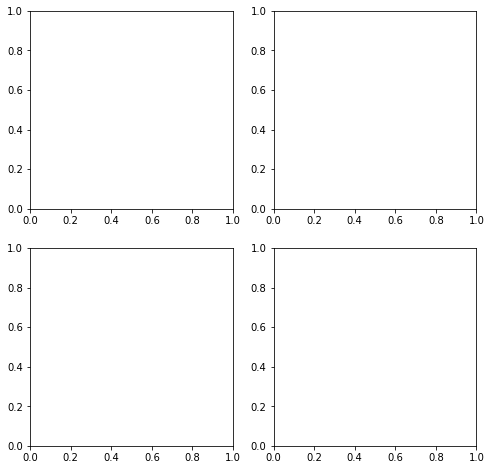